In [21]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
lx_file = "./data/201909_lx_events.csv"
    
objects = ("XAZR_LX_12_4","XAZR_LX_7_0","XR_LX_10_1","XR_LX_11_7","XR_LX_12_1t1","XR_LX_12_1t2","XR_LX_12_4",
            "XR_LX_12_6","XR_LX_13_7","XR_LX_14_9","XR_LX_15_6","XR_LX_21_3","XR_LX_23_1_1","XR_LX_23_1_2",
            "XR_LX_23_2_1","XR_LX_23_2_2","XR_LX_5_3","XR_LX_5_4","XR_LX_5_5t1","XR_LX_5_5t2","XR_LX_6_0",
            "XR_LX_7_0","XR_LX_7_7t1","XR_LX_7_7t2","XCPR_LX_10_1","XCPR_LX_11_7","XCPR_LX_12_1t1","XCPR_LX_12_1t2",
            "XCPR_LX_12_4","XCPR_LX_12_6","XCPR_LX_13_7","XCPR_LX_14_9","XCPR_LX_15_6","XCPR_LX_21_3","XCPR_LX_23_1_1",
            "XCPR_LX_23_1_2","XCPR_LX_23_2_1","XCPR_LX_23_2_2","XCPR_LX_5_3","XCPR_LX_5_4","XCPR_LX_5_5t1","XCPR_LX_5_5t2",
            "XCPR_LX_6_0","XCPR_LX_7_0","XCPR_LX_7_7t1","XCPR_LX_7_7t2","XKTEPR_LX_10_1","XKTEPR_LX_11_7","XKTEPR_LX_12_1t1",
            "XKTEPR_LX_12_1t2","XKTEPR_LX_12_4","XKTEPR_LX_12_6","XKTEPR_LX_13_7","XKTEPR_LX_14_9","XKTEPR_LX_15_6",
            "XKTEPR_LX_21_3","XKTEPR_LX_23_1_1","XKTEPR_LX_23_1_2","XKTEPR_LX_23_2_1","XKTEPR_LX_23_2_2","XKTEPR_LX_5_3",
            "XKTEPR_LX_5_4","XKTEPR_LX_5_5t1","XKTEPR_LX_5_5t2","XKTEPR_LX_6_0","XKTEPR_LX_7_0","XKTEPR_LX_7_7t1","XKTEPR_LX_7_7t2")

In [3]:
datecol = ['datetime']
df = pd.read_csv(lx_file, sep=';', parse_dates=datecol, dayfirst=True, infer_datetime_format=True)

In [4]:
df.drop(columns=['logfile','type','event'], inplace=True)

In [5]:
df.sort_values(by='datetime', inplace=True)
df.reset_index(drop=True, inplace=True)
df[['func','lx']] = df.object.str.split('_',1, expand=True)

In [6]:
df['lx_closed_time'] = ""
df['lx_closed_time'] = pd.to_numeric(df.lx_closed_time)
df['lx_alarm_time'] = ""
df['lx_alarm_time'] = pd.to_numeric(df.lx_alarm_time)
df['deltaT_func'] = ""
df['deltaT0_1'] = ""
df['deltaT0_2'] = ""
df['deltaT0_L'] = ""
df['deltaT_lx'] = ""
df['lx_open_error'] = ""
df['lx_passage'] = ""
df['lx_other_error'] = ""
df['lx_input_error'] = ""
df['lx_closed_long'] = ""
df['lx_xcpr_repeat'] = ""
df['lx_xktepr_repeat'] = ""
df['lx_note'] = ""

tmin = df.datetime.min()
tmax = df.datetime.max()
maxsec = int((tmax-tmin)/np.timedelta64(1,'s'))
lx_name = set(df.lx)

In [7]:
new_df = pd.DataFrame()
    
for lx in objects:
    new_df = df[df.object==lx]
    new_df = new_df.assign(deltaT_func = lambda x: (x.datetime - x.datetime.shift(1, axis = 0))/np.timedelta64(1,'s')) # delta tijd per functie event
    new_df = new_df.assign(deltaT0_1 = lambda x: (x.datetime - tmin)/np.timedelta64(1,'s'))
    new_df = new_df.assign(deltaT0_2 = lambda x: x.deltaT0_1.shift(-1, axis = 0))
    new_df.loc[new_df.deltaT0_2.isnull(), 'deltaT0_2'] = maxsec
    new_df = new_df.assign(deltaT0_L = lambda x: x.deltaT0_2 - x.deltaT0_1)
    df.update(new_df)

In [8]:
df.sort_values(by='datetime', inplace=True)

for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.assign(deltaT_lx = lambda x: (x.datetime - x.datetime.shift(1, axis = 0))/np.timedelta64(1,'s')) # delta tijd per lx event
    df.update(new_df)

In [9]:
functions = ['XR','XCPR'] 
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.sort_values(by='datetime')
    new_df = new_df[new_df.func.isin(functions)] # maak een dataframe met alleen xr en xcpr
    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)>=1)) & 
                ((new_df['func'].shift(2)=='XR') & (new_df['value'].shift(2)>=1)) & 
                ((new_df['func'].shift(3)=='XR') & (new_df['value'].shift(3)==1))), 
                ['lx_passage','lx_note']] = ["LX double passage"]*2
   
    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XR') & (new_df['value'].shift(1)==2)) & 
                ((new_df['func'].shift(2)=='XR') & (new_df['value'].shift(2)==1)) & 
                ((new_df['func'].shift(3)=='XCPR') & (new_df['value'].shift(3)==2)) & 
                ((new_df['func'].shift(4)=='XR') & (new_df['value'].shift(4)==1))), 
                ['lx_passage','lx_note']] = ["LX single passage"]*2

    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) &  
                ((new_df['func'].shift(1)!='XR'))), 
                ['lx_open_error','lx_note']] = ["XCPR off and no XR on before"]*2
    df.update(new_df)

In [10]:

functions = ['XR','XCPR','XKTEPR'] 
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df.sort_values(by='datetime')
    new_df = new_df[new_df.func.isin(functions)] # maak een dataframe met alleen xr en xcpr en xktepr
        
    new_df.loc[((new_df.value.isin([0,3])) & (new_df.func.isin(functions[1:]))), 
                ['lx_input_error','lx_note']] = ["Short/OOC on input"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XR') & (new_df.value.shift(1)==2))), 
                ['lx_other_error','lx_note']] = ["XKTEPR off after XR on"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XCPR') & (new_df.value.shift(1)>=1))), 
                ['lx_closed_long','lx_note']] = ["LX closed too long"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(1)=='XR') & (new_df.value.shift(1)==1))), 
                ['lx_closed_long','lx_note']] = ["LX closed too long"]*2

    new_df.loc[(((new_df.func=='XKTEPR') & (new_df.value==1)) & 
                ((new_df.func.shift(-1)=='XKTEPR') & (new_df.value.shift(-1)==2))), 
                ['lx_xktepr_repeat','lx_note']] = ["XKTEPR repeat"]*2

    new_df.loc[(((new_df.func=='XCPR') & (new_df.value==2)) & 
                ((new_df.func.shift(1)=='XCPR') & (new_df.value.shift(1)==1)) &  
                ((new_df.func.shift(2)=='XCPR'))), 
                ['lx_xcpr_repeat','lx_note']] =   ["XCPR repeat"]*2
    df.update(new_df)


In [11]:
# bepaal de lx_closed_time
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func=='XCPR']
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XCPR') & (new_df['value']==1)) & 
                ((new_df['func'].shift(1)=='XCPR') & (new_df['value'].shift(1)==2))), 
                ['lx_closed_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

In [12]:
#bepaal de lx_alarm_time
for lx in lx_name:
    new_df = df[df.lx==lx]
    new_df = new_df[new_df.func=='XKTEPR']
    new_df = new_df.sort_values(by='datetime')

    new_df.loc[(((new_df['func']=='XKTEPR') & (new_df['value']==2)) & 
                ((new_df['func'].shift(1)=='XKTEPR') & (new_df['value'].shift(1)==1))), 
                ['lx_alarm_time']] = new_df.deltaT0_1 - new_df.deltaT0_1.shift(1)

    df.update(new_df)

## Data voor de statistiek
- lx_xcpr_time
- lx_xktepr_time
- lx_passage

In [13]:
lx_xcpr_time = df.query("func=='XCPR' & value==1")[['datetime','lx','lx_closed_time']]

lx_xktepr_time = df.query("func=='XKTEPR' & value==2")[['datetime','lx','lx_alarm_time']]

lx_passage = df.query("lx_passage !=''")[['datetime','lx','lx_passage']]

# Bepaal de tijd dat de overwegbomen laag zijn:

In [14]:
lx_passage.groupby(['lx','lx_passage']).count().unstack()


datetime                  
lx_passage LX double passage LX single passage
lx                                            
LX_10_1                 26.0            1383.0
LX_11_7                 36.0            1377.0
LX_12_1t1                7.0             640.0
LX_12_4                 91.0            1121.0
LX_12_6                125.0            1046.0
LX_13_7                231.0             829.0
LX_14_9                238.0             124.0
LX_15_6                 18.0             657.0
LX_21_3                  9.0             672.0
LX_5_3                 237.0            1520.0
LX_5_4                 976.0             777.0
LX_5_5t1                48.0             934.0
LX_5_5t2               637.0             345.0
LX_6_0                 198.0            1608.0
LX_7_7t1                54.0             707.0
LX_7_7t2                 NaN             672.0

In [15]:
lx_xcpr_time.groupby(['lx']).describe().round(1)

lx_closed_time                                             
                   count  mean    std   min   25%   50%   75%     max
lx                                                                   
LX_10_1           1411.0  18.5    3.7  15.0  17.0  18.0  19.0    78.0
LX_11_7           1420.0  36.6   28.3   3.0  27.0  32.0  36.0   561.0
LX_12_1t1          650.0  27.0   16.5  17.0  22.0  24.0  28.0   311.0
LX_12_4           1216.0  28.6   14.3  17.0  23.0  26.0  29.0   312.0
LX_12_6           1185.0  30.2   13.9   1.0  24.0  27.0  30.0   244.0
LX_13_7           1089.0  39.1  152.5   0.0  22.0  25.0  30.0  4445.0
LX_14_9            364.0  28.5   22.3  16.0  22.0  24.0  28.2   350.0
LX_15_6            679.0  21.0    7.2   0.0  18.0  20.0  22.0   142.0
LX_21_3            687.0  18.2    8.5   2.0  15.0  16.0  19.0   142.0
LX_5_3            1760.0  28.9    9.6  19.0  24.0  26.0  30.2   174.0
LX_5_4            1759.0  30.9   10.1  20.0  25.0  29.0  32.0   183.0
LX_5_5t1           983.0  26.8    9.1  18.0  23.0  26.0  28.0   181.0
LX_5_5t2           983.0  25.0    5.6  17.0  21.0  24.0  27.0    64.0
LX_6_0            1820.0  35.2   17.1   0.0  27.0  32.0  37.0   317.0
LX_7_7t1           773.0  28.5   19.0   2.0  22.0  24.0  30.0   261.0
LX_7_7t2           673.0  27.7    6.6  17.0  24.0  27.0  29.0   124.0

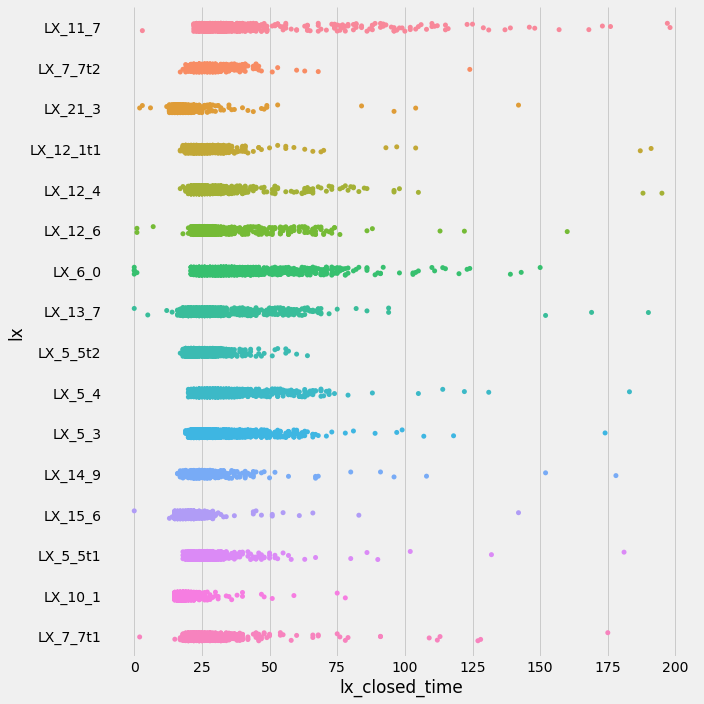

In [22]:
pl1 = sns.catplot('lx_closed_time','lx', data=lx_xcpr_time[lx_xcpr_time.lx_closed_time <= 200], height=10, kind='strip')

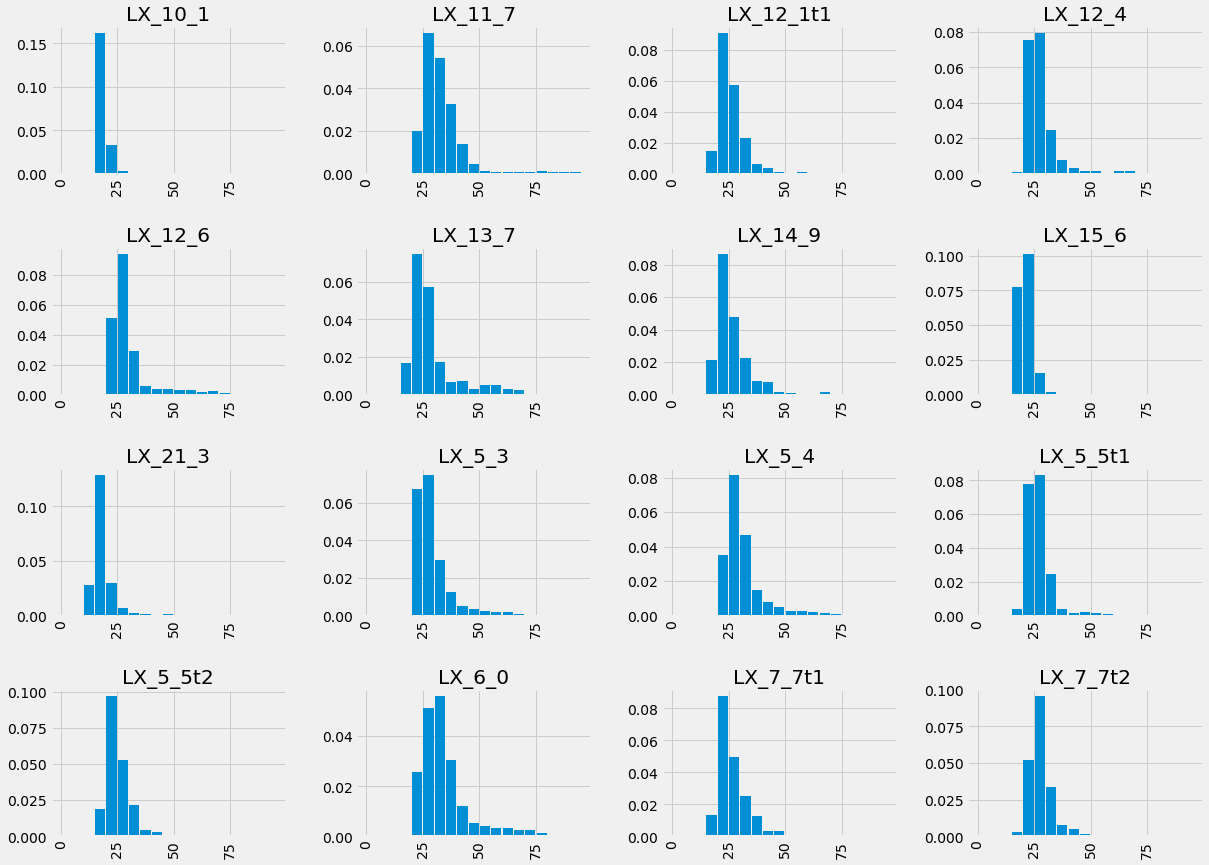

In [23]:
pl2 = lx_xcpr_time.hist(column='lx_closed_time', bins=list(range(0,100,5)), by='lx',
                        density=True, figsize=(20,15), rwidth=0.9, layout=(4,4))

## Overweg dicht tijd >= 30sec

In [25]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time >= 30].groupby(['lx']).describe().round(1)

lx_closed_time                                             
                   count  mean    std   min   25%   50%   75%     max
lx                                                                   
LX_10_1             16.0  43.9   15.2  30.0  33.2  39.0  48.8    78.0
LX_11_7            827.0  44.3   35.1  30.0  33.0  35.0  40.0   561.0
LX_12_1t1          124.0  42.0   33.4  30.0  31.0  33.0  38.0   311.0
LX_12_4            276.0  42.1   25.4  30.0  31.0  34.0  41.0   312.0
LX_12_6            327.0  42.6   21.7  30.0  31.0  34.0  48.5   244.0
LX_13_7            284.0  83.9  294.4  30.0  33.0  42.0  55.0  4445.0
LX_14_9             85.0  46.7   41.1  30.0  31.0  35.0  43.0   350.0
LX_15_6             19.0  49.8   26.5  30.0  32.5  44.0  53.0   142.0
LX_21_3             23.0  50.4   28.7  30.0  32.5  40.0  49.0   142.0
LX_5_3             513.0  39.0   12.8  30.0  32.0  34.0  41.0   174.0
LX_5_4             737.0  37.9   12.3  30.0  31.0  34.0  40.0   183.0
LX_5_5t1           174.0  37.6   17.0  30.0  31.0  32.0  37.0   181.0
LX_5_5t2           155.0  34.8    6.5  30.0  30.5  32.0  36.0    64.0
LX_6_0            1122.0  41.4   19.2  30.0  32.0  35.0  42.0   317.0
LX_7_7t1           196.0  43.9   32.9  30.0  32.0  35.0  40.0   261.0
LX_7_7t2           168.0  35.0    9.2  30.0  30.8  32.0  36.2   124.0

## Overweg dicht tijd <= 180sec

In [26]:
lx_xcpr_time[lx_xcpr_time.lx_closed_time <= 180].groupby(['lx']).describe().round(1)

lx_closed_time                                           
                   count  mean   std   min   25%   50%   75%    max
lx                                                                 
LX_10_1           1411.0  18.5   3.7  15.0  17.0  18.0  19.0   78.0
LX_11_7           1411.0  35.0  17.0   3.0  27.0  32.0  36.0  176.0
LX_12_1t1          647.0  26.1   8.1  17.0  22.0  24.0  28.0  104.0
LX_12_4           1213.0  28.1   9.7  17.0  23.0  26.0  29.0  105.0
LX_12_6           1183.0  29.8  11.0   1.0  24.0  27.0  30.0  160.0
LX_13_7           1077.0  28.7  12.7   0.0  22.0  25.0  30.0  169.0
LX_14_9            363.0  27.7  14.6  16.0  22.0  24.0  28.0  178.0
LX_15_6            679.0  21.0   7.2   0.0  18.0  20.0  22.0  142.0
LX_21_3            687.0  18.2   8.5   2.0  15.0  16.0  19.0  142.0
LX_5_3            1760.0  28.9   9.6  19.0  24.0  26.0  30.2  174.0
LX_5_4            1758.0  30.8   9.4  20.0  25.0  28.5  32.0  131.0
LX_5_5t1           982.0  26.6   7.6  18.0  23.0  26.0  28.0  132.0
LX_5_5t2           983.0  25.0   5.6  17.0  21.0  24.0  27.0   64.0
LX_6_0            1816.0  34.8  13.9   0.0  27.0  32.0  37.0  150.0
LX_7_7t1           770.0  27.6  12.5   2.0  22.0  24.0  29.8  175.0
LX_7_7t2           673.0  27.7   6.6  17.0  24.0  27.0  29.0  124.0

# Duur van storingsmelder actief in seconden:


In [27]:
lx_xktepr_time.groupby(['lx']).describe().round(1)

lx_alarm_time                                                 \
                  count    mean     std    min     25%     50%     75%   
lx                                                                       
LX_11_7            12.0   102.8   119.6    8.0    30.0    66.0   100.2   
LX_12_1t1           3.0    68.3    69.9   26.0    28.0    30.0    89.5   
LX_12_4             3.0    72.3    69.1   29.0    32.5    36.0    94.0   
LX_12_6             2.0    75.5    12.0   67.0    71.2    75.5    79.8   
LX_13_7             2.0  6266.0  8690.3  121.0  3193.5  6266.0  9338.5   
LX_14_9             2.0   103.5   122.3   17.0    60.2   103.5   146.8   
LX_15_6             4.0   672.8   885.7   39.0   120.8   345.5   897.5   
LX_21_3             6.0   658.3   697.9    1.0    59.0   563.0  1142.0   
LX_5_3              1.0    12.0     NaN   12.0    12.0    12.0    12.0   
LX_5_4              1.0    22.0     NaN   22.0    22.0    22.0    22.0   
LX_5_5t1            1.0    20.0     NaN   20.0    20.0    20.0    20.0   
LX_6_0              4.0    83.0    50.0   47.0    59.0    64.0    88.0   
LX_7_7t1            4.0    76.5    42.5   13.0    72.2    96.0   100.2   

                    
               max  
lx                  
LX_11_7      399.0  
LX_12_1t1    149.0  
LX_12_4      152.0  
LX_12_6       84.0  
LX_13_7    12411.0  
LX_14_9      190.0  
LX_15_6     1961.0  
LX_21_3     1597.0  
LX_5_3        12.0  
LX_5_4        22.0  
LX_5_5t1      20.0  
LX_6_0       157.0  
LX_7_7t1     101.0